In [ ]:
# Standard libraries
import os
import io
import gzip
import shutil
import random
import zipfile
import requests
from pathlib import Path

# Numerical and Data Processing
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# TensorFlow & Keras (Deep Learning)
import tensorflow as tf
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.models import Sequential
from tensorflow.keras.activations import swish
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.layers import Dense, Activation, Flatten, InputLayer, Conv2D, MaxPooling2D, Dropout, BatchNormalization

In [ ]:
def download_emnist(target_dir='emnist'):
    """
    Download EMNIST dataset from NIST website as zip file and extract only balanced dataset files
    Args:
        target_dir: Directory to save extracted files (default: 'emnist')
    """
    # Create target directory if it doesn't exist
    os.makedirs(target_dir, exist_ok=True)

    # URL for the complete EMNIST gzip zip file
    zip_url = "https://biometrics.nist.gov/cs_links/EMNIST/gzip.zip"

    # Files we want to extract from the zip (balanced dataset only)
    balanced_files = {
        'emnist-balanced-mapping.txt',
        'emnist-balanced-test-images-idx3-ubyte.gz',
        'emnist-balanced-test-labels-idx1-ubyte.gz',
        'emnist-balanced-train-images-idx3-ubyte.gz',
        'emnist-balanced-train-labels-idx1-ubyte.gz'
    }

    print(f"Downloading EMNIST dataset from {zip_url}...")
    try:
        # Download the zip file
        response = requests.get(zip_url, stream=True)
        response.raise_for_status()  # Raise error for bad status codes

        # Use zipfile to extract only the files we need
        with zipfile.ZipFile(io.BytesIO(response.content)) as zip_ref:
            # Get list of all files in zip
            all_files = zip_ref.namelist()

            # Extract only balanced dataset files
            for file in all_files:
                # Remove any directory structure from the zip
                base_name = os.path.basename(file)
                if base_name in balanced_files:
                    print(f"Extracting {base_name}...")
                    # Extract to target directory
                    with zip_ref.open(file) as zf, open(os.path.join(target_dir, base_name), 'wb') as f:
                        f.write(zf.read())

        print("EMNIST Balanced dataset download and extraction complete!")

    except Exception as e:
        print(f"Error downloading EMNIST dataset: {e}")
        # Clean up partially downloaded files if error occurs
        for file in balanced_files:
            if os.path.exists(os.path.join(target_dir, file)):
                os.remove(os.path.join(target_dir, file))
        raise

In [ ]:
def load_emnist():
    def extract_images(filename):
        with gzip.open(filename, 'rb') as f:
            data = np.frombuffer(f.read(), np.uint8, offset=16)
        # EMNIST images are stored transposed and need reshaping
        data = data.reshape(-1, 28, 28)
        # Rotate and flip to correct orientation
        data = np.transpose(data, (0, 2, 1))
        data = np.flip(data, axis=1)
        return data

    def extract_labels(filename):
        with gzip.open(filename, 'rb') as f:
            return np.frombuffer(f.read(), np.uint8, offset=8)

    print("Loading EMNIST Balanced dataset...")
    try:
        X_train = extract_images('emnist/emnist-balanced-train-images-idx3-ubyte.gz')
        y_train = extract_labels('emnist/emnist-balanced-train-labels-idx1-ubyte.gz')
        X_test = extract_images('emnist/emnist-balanced-test-images-idx3-ubyte.gz')
        y_test = extract_labels('emnist/emnist-balanced-test-labels-idx1-ubyte.gz')
        return (X_train, y_train), (X_test, y_test)
    except Exception as e:
        print(f"Error loading EMNIST: {e}")
        return None

In [ ]:
def load_label_mapping(filepath='emnist/emnist-balanced-mapping.txt'):
    mapping = {}
    with open(filepath, 'r') as f:
        for line in f:
            label, ascii_code = map(int, line.strip().split())
            mapping[label] = chr(ascii_code)
    return mapping

In [ ]:
# Download and load dataset
download_emnist()

Extracting emnist-balanced-mapping.txt...
Extracting emnist-balanced-test-images-idx3-ubyte.gz...
Extracting emnist-balanced-test-labels-idx1-ubyte.gz...
Extracting emnist-balanced-train-images-idx3-ubyte.gz...
Extracting emnist-balanced-train-labels-idx1-ubyte.gz...
EMNIST Balanced dataset download and extraction complete!


In [ ]:
!ls emnist

emnist-balanced-mapping.txt
emnist-balanced-test-images-idx3-ubyte.gz
emnist-balanced-test-labels-idx1-ubyte.gz
emnist-balanced-train-images-idx3-ubyte.gz
emnist-balanced-train-labels-idx1-ubyte.gz


In [ ]:
(X_train_full, y_train_full), (X_test_full, y_test_full) = load_emnist()

Loading EMNIST Balanced dataset...



Displaying 25 random sample images...


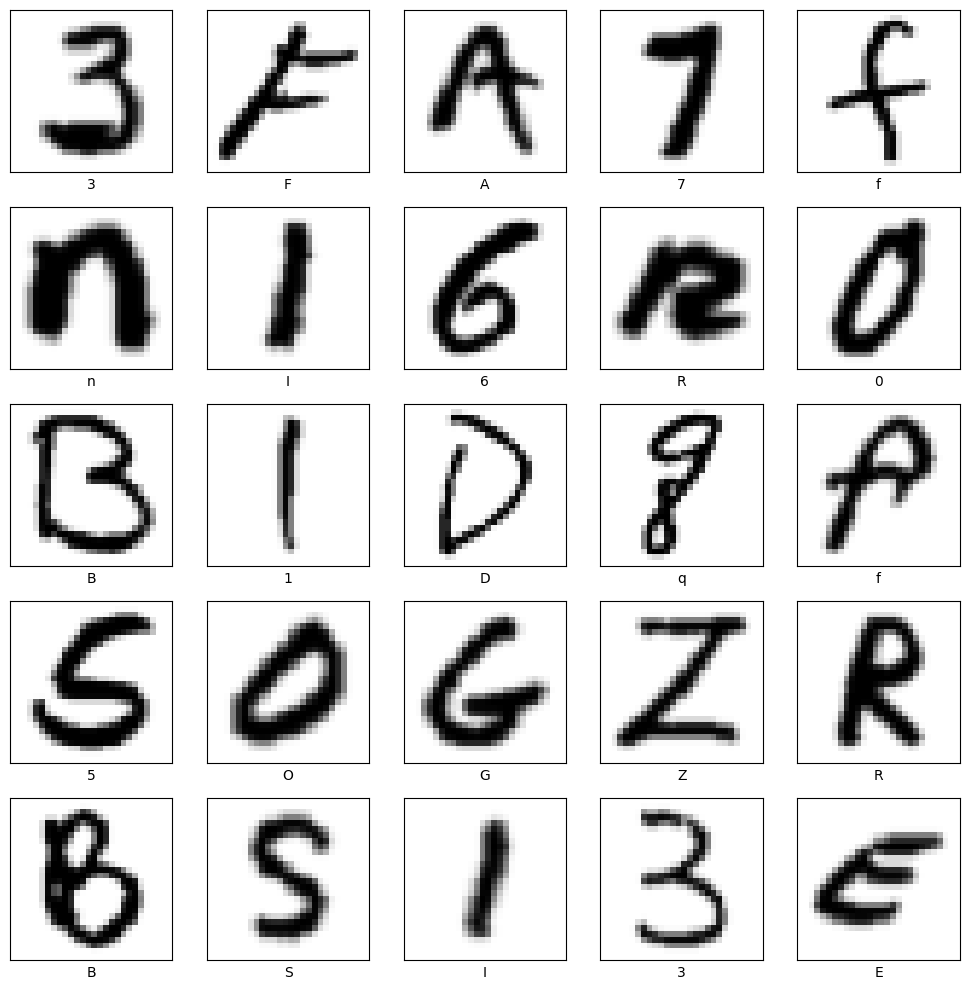

In [ ]:
# Visualize 25 random sample images with correct labels
print("\nDisplaying 25 random sample images...")
label_map = load_label_mapping()  # Load mapping from file

plt.figure(figsize=(10, 10))
random_indices = np.random.choice(len(X_train_full), 25, replace=False)  # Select 25 unique indices

for i, idx in enumerate(random_indices):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)

    # Rotate the image
    rotated_image = np.rot90(X_train_full[idx].T)

    plt.imshow(rotated_image, cmap=plt.cm.binary)  # Display rotated image
    label = label_map.get(int(y_train_full[idx]), '?')
    plt.xlabel(label)

plt.tight_layout()
plt.show()

In [ ]:
# Normalize pixel values
X_train = X_train_full.astype('float32') / 255.0
X_test = X_test_full.astype('float32') / 255.0

# Flatten 28x28 images to 784 vector (needed for MLP)
X_train = X_train.reshape(-1, 28*28)
X_test = X_test.reshape(-1, 28*28)

# One-hot encode labels
y_train = to_categorical(y_train_full)
y_test = to_categorical(y_test_full)

# Confirm shape
print("Train shape:", X_train.shape, y_train.shape)
print("Test shape:", X_test.shape, y_test.shape)

Train shape: (112800, 784) (112800, 47)
Test shape: (18800, 784) (18800, 47)


In [ ]:
model = Sequential([
    Dense(1024, activation='relu', input_shape=(784,), kernel_regularizer=l2(2e-4)),
    BatchNormalization(),
    Dropout(0.4),

    Dense(768, activation='relu', kernel_regularizer=l2(2e-4)),
    BatchNormalization(),
    Dropout(0.4),

    Dense(512, activation=swish),
    BatchNormalization(),
    Dropout(0.3),

    Dense(256, activation=swish),
    Dropout(0.2),

    Dense(y_train.shape[1], activation='softmax')
])

In [ ]:
# Optimizer with decoupled weight decay
optimizer = AdamW(learning_rate=5e-4, weight_decay=1e-4)

# Categorical crossentropy with label smoothing
loss_fn = CategoricalCrossentropy(label_smoothing=0.1)

model.compile(optimizer=optimizer,
              loss=loss_fn,
              metrics=['accuracy'])

In [ ]:
# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)

# Train model
history = model.fit(X_train, y_train,
                    validation_split=0.1,
                    epochs=120,
                    batch_size=128,
                    callbacks=[early_stop, lr_scheduler])

Epoch 1/120
794/794 ━━━━━━━━━━━━━━━━━━━━ 68s 80ms/step - accuracy: 0.4799 - loss: 2.6782 - val_accuracy: 0.7851 - val_loss: 1.6412 - learning_rate: 5.0000e-04
Epoch 2/120
794/794 ━━━━━━━━━━━━━━━━━━━━ 58s 73ms/step - accuracy: 0.7402 - loss: 1.7601 - val_accuracy: 0.8119 - val_loss: 1.5040 - learning_rate: 5.0000e-04
Epoch 3/120
794/794 ━━━━━━━━━━━━━━━━━━━━ 85s 77ms/step - accuracy: 0.7779 - loss: 1.5965 - val_accuracy: 0.8241 - val_loss: 1.4312 - learning_rate: 5.0000e-04
Epoch 4/120
794/794 ━━━━━━━━━━━━━━━━━━━━ 81s 75ms/step - accuracy: 0.7994 - loss: 1.5037 - val_accuracy: 0.8334 - val_loss: 1.3700 - learning_rate: 5.0000e-04
Epoch 5/120
794/794 ━━━━━━━━━━━━━━━━━━━━ 60s 76ms/step - accuracy: 0.8141 - loss: 1.4370 - val_accuracy: 0.8369 - val_loss: 1.3392 - learning_rate: 5.0000e-04
Epoch 6/120
794/794 ━━━━━━━━━━━━━━━━━━━━ 81s 75ms/step - accuracy: 0.8196 - loss: 1.3950 - val_accuracy: 0.8369 - val_loss: 1.3077 - learning_rate: 5.0000e-04
Epoch 7/120
794/794 ━━━━━━━━━━━━━━━━━━━━ 82s 7

In [ ]:
# Find the epoch index with the lowest validation loss
best_epoch = np.argmin(history.history['val_loss'])

# Retrieve accuracy metrics for the best model
best_train_acc = history.history['accuracy'][best_epoch]
best_val_acc = history.history['val_accuracy'][best_epoch]

print(f"Best Model Accuracy: Epoch {best_epoch+1}")
print(f"Training Accuracy: {best_train_acc:.4f}")
print(f"Validation Accuracy: {best_val_acc:.4f}")

# Evaluate on test data (which uses restored best weights)
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:.4f}")

Best Model Accuracy: Epoch 72
Training Accuracy: 0.9210
Validation Accuracy: 0.8750
588/588 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.8787 - loss: 1.0682
Test Accuracy: 0.8798


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


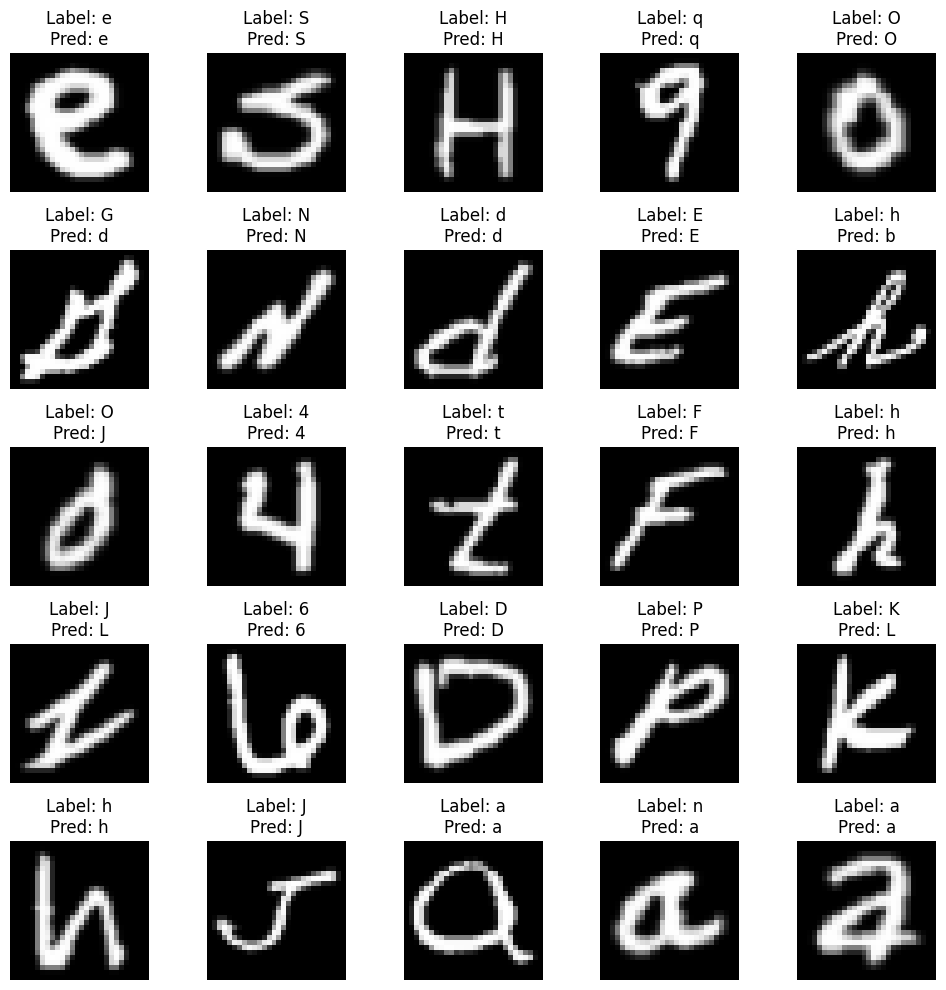

In [ ]:
plt.figure(figsize=(10, 10))

for i in range(25):
    idx = random.randint(0, len(X_test_full) - 1)

    # Rotate image 270° clockwise (equivalent to k=3 in np.rot90)
    rotated_image = np.rot90(X_test_full[idx].T, k=1)

    # Get correct label and predicted label
    label = np.argmax(y_test[idx])
    pred = np.argmax(model.predict(X_test_full[idx].reshape(1, -1)))

    # Apply label mapping
    label_text = label_map.get(label, '?')
    pred_text = label_map.get(pred, '?')

    # Display the rotated image
    plt.subplot(5, 5, i + 1)
    plt.imshow(rotated_image, cmap='gray')
    plt.title(f"Label: {label_text}\nPred: {pred_text}")
    plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# Predict class labels
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Generate classification report
print("Classification Report:")
print(classification_report(y_true, y_pred_classes, digits=4))

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred_classes))

588/588 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step
Classification Report:
              precision    recall  f1-score   support

           0     0.6510    0.7600    0.7013       400
           1     0.5475    0.7200    0.6220       400
           2     0.9193    0.8825    0.9005       400
           3     0.9726    0.9750    0.9738       400
           4     0.9342    0.9225    0.9283       400
           5     0.9407    0.8725    0.9053       400
           6     0.9323    0.9300    0.9312       400
           7     0.9703    0.9800    0.9751       400
           8     0.9298    0.9275    0.9287       400
           9     0.6769    0.8275    0.7447       400
          10     0.9628    0.9700    0.9664       400
          11     0.9451    0.9475    0.9463       400
          12     0.9645    0.9500    0.9572       400
          13     0.9258    0.9050    0.9153       400
          14     0.9700    0.9700    0.9700       400
          15     0.7025    0.5725    0.6309       400
          16     

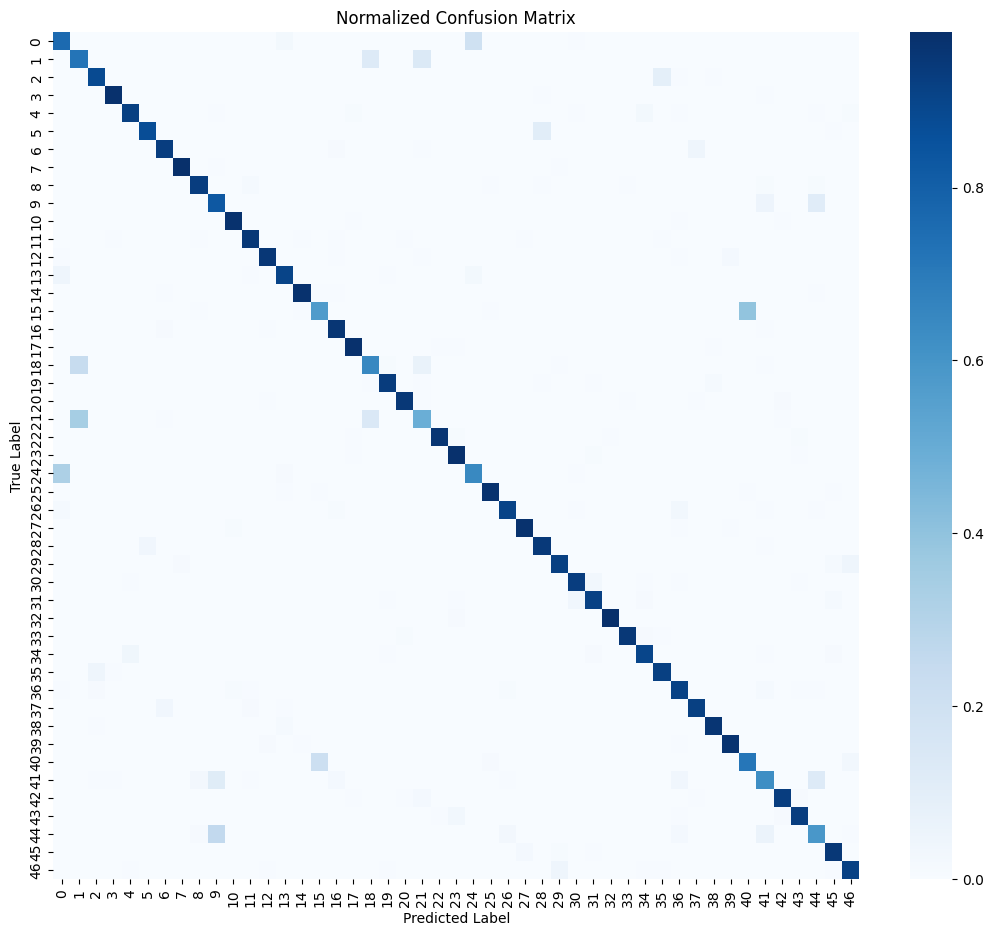

In [ ]:
# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(13, 11))
sns.heatmap(cm / cm.sum(axis=1, keepdims=True), annot=False, cmap='Blues')
plt.title('Normalized Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()